In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing.image import image_dataset_from_directory
import os
from PIL import Image
from model_params import *
from dataTransformer import *
#tf.disable_v2_behavior()
import time


%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Loading data

In [4]:
DATA_ROOT = "asl_alphabet_train/"
batch_size = BATCH_SIZE
img_height,img_width,img_channels = IMG_DIM

seed = 12353
validation_split = 0.2
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
raw_train,val_ds,test_ds,class_names = load_dataset(DATA_ROOT,seed=seed)
num_classes = len(class_names)
train_ds = raw_train.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

Found 87000 files belonging to 29 classes.
Using 52200 files for training.
Found 87000 files belonging to 29 classes.
Using 34800 files for validation.


In [5]:
# train_ds = image_dataset_from_directory(DATA_ROOT,shuffle=True,
#                                                        validation_split=validation_split*2,
#                                                        image_size=(img_height, img_width),
#                                                        batch_size=batch_size,
#                                                        subset="training",
#                                                        seed=seed)
# val_test_ds = image_dataset_from_directory(DATA_ROOT,shuffle=True,
#                                                        validation_split=validation_split*2,
#                                                        image_size=(img_height, img_width),
#                                                        batch_size=batch_size,
#                                                        subset="validation",
#                                                        seed=seed)
# val_ds = val_test_ds.skip(len(val_test_ds)//2)
# test_ds = val_test_ds.take(len(val_test_ds)//2)
# class_names = train_ds.class_names
# print(class_names)
# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# num_classes = len(class_names)

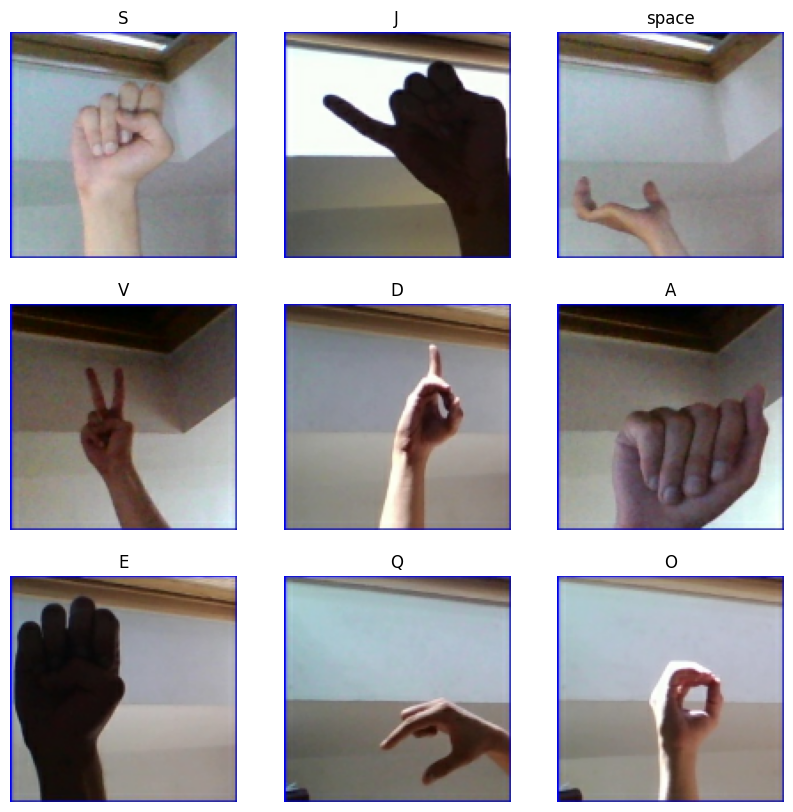

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

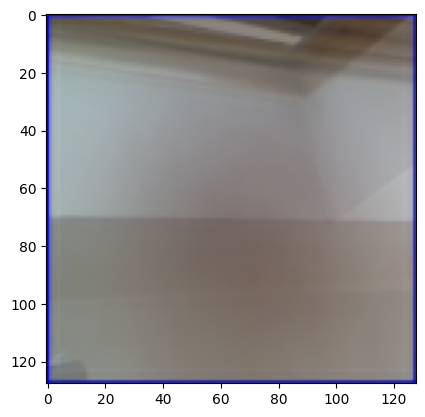

In [6]:
running_mean = tf.zeros(IMG_DIM)
img_num = 0
for imgs, lables in train_ds.take(100):
    
    running_mean = (img_num*running_mean+imgs.shape[0]*(tf.math.reduce_mean(imgs,0)/255))/(imgs.shape[0] + img_num)
    img_num+=imgs.shape[0]

plt.imshow(running_mean.numpy())

## Baseline model

Simple linear regression

In [7]:
lr_model = tf.keras.Sequential([
  tf.keras.layers.Resizing(INPUT_SHAPE[0],INPUT_SHAPE[1]),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes)
])

#using rms optimizer 
lr_model.compile(
  optimizer='rmsprop',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [8]:
history = lr_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100
)

Epoch 1/2
1632/1632 [==============================] - 11s 6ms/step - loss: 6.4261 - accuracy: 0.1156 - val_loss: 10.5300 - val_accuracy: 0.0647
Epoch 2/2
1632/1632 [==============================] - 7s 4ms/step - loss: 5.2305 - accuracy: 0.1853 - val_loss: 7.2263 - val_accuracy: 0.1458


In [9]:
lr_res = evaluate_model(lr_model,test_ds,verbose=3,savePath="lr_model.keras")

544/544 [==============================] - 6s 7ms/step - loss: 7.3104 - accuracy: 0.1450
Test loss: 7.310363292694092
Test accuracy: 0.14500920474529266
Model saved to lr_model.keras


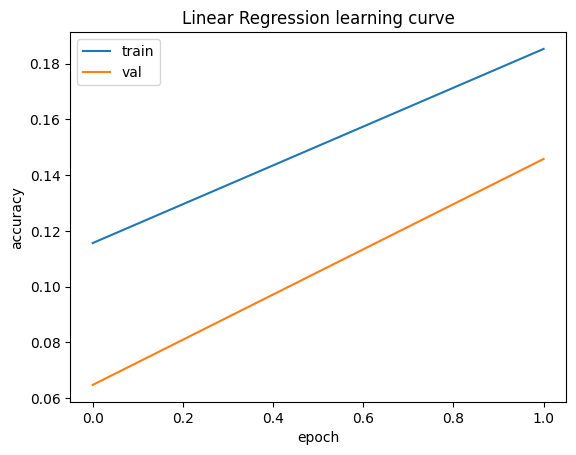

In [11]:
plot_learning_curve(history, title="Linear Regression learning curve",save_fig=True)

## Neural Network

In [12]:
nn_model = tf.keras.Sequential([
  tf.keras.layers.Resizing(INPUT_SHAPE[0],INPUT_SHAPE[1]),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(num_classes)
])
nn_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [13]:
history = nn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/2
1632/1632 [==============================] - 10s 6ms/step - loss: 2.3647 - accuracy: 0.2585 - val_loss: 2.1001 - val_accuracy: 0.3120
Epoch 2/2
1632/1632 [==============================] - 8s 5ms/step - loss: 1.4278 - accuracy: 0.5058 - val_loss: 1.2368 - val_accuracy: 0.5641


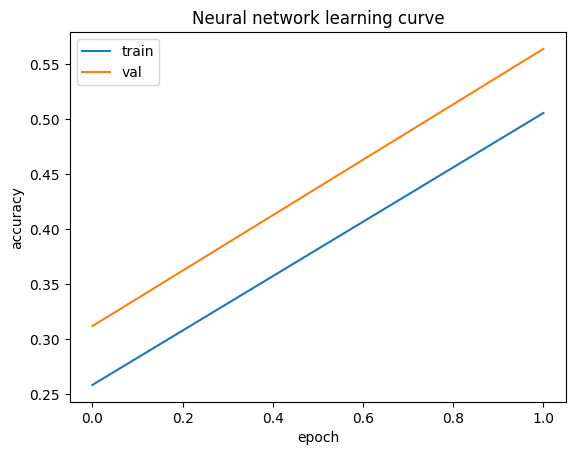

In [14]:
plot_learning_curve(history, title="Neural network learning curve",save_fig=True)

In [15]:
nn_model_res = evaluate_model(nn_model,test_ds,verbose=3,savePath="neural_model.keras")

544/544 [==============================] - 2s 4ms/step - loss: 1.2342 - accuracy: 0.5649
Test loss: 1.2342392206192017
Test accuracy: 0.564914882183075
Model saved to neural_model.keras


## Preprocessing


In [13]:

from dataTransformer import *
train_ds_t = preprocess_ds(raw_train.cache(),preprocess,train=True).batch(batch_size,num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
val_ds_t = preprocess_ds(val_ds,preprocess).prefetch(buffer_size=AUTOTUNE)
test_ds_t = preprocess_ds(test_ds,preprocess).prefetch(buffer_size=AUTOTUNE)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.3087327


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


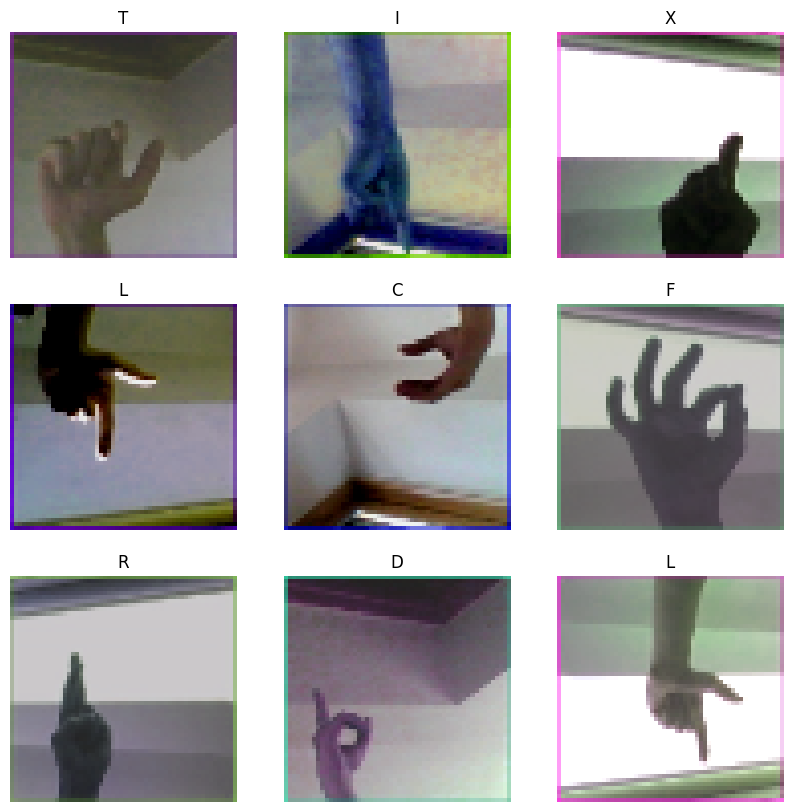

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_t.take(1):
  print(np.amax(images.numpy()))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

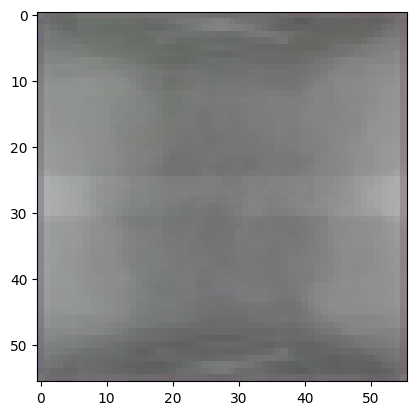

In [15]:
running_mean = tf.zeros(INPUT_SHAPE)
img_num = 0
for imgs, lables in train_ds_t.take(5):
    
    running_mean = (img_num*running_mean+imgs.shape[0]*(tf.math.reduce_mean(imgs,0)))/(imgs.shape[0] + img_num)
    img_num+=imgs.shape[0]

plt.imshow(running_mean.numpy())

## Neural network - Again

same model, 2.5m parameters

In [16]:
nn_model_t = tf.keras.Sequential([
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(num_classes)
])
nn_model_t.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [17]:
history = nn_model_t.fit(
  train_ds_t,
  validation_data=val_ds_t,
  epochs=50
)

Epoch 1/50
1632/1632 [==============================] - 16s 10ms/step - loss: 3.2595 - accuracy: 0.0681 - val_loss: 3.1245 - val_accuracy: 0.0939
Epoch 2/50
1632/1632 [==============================] - 8s 5ms/step - loss: 3.0007 - accuracy: 0.1036 - val_loss: 2.7792 - val_accuracy: 0.1393
Epoch 3/50
1632/1632 [==============================] - 8s 5ms/step - loss: 2.7858 - accuracy: 0.1419 - val_loss: 2.7399 - val_accuracy: 0.1577
Epoch 4/50
1632/1632 [==============================] - 8s 5ms/step - loss: 2.6480 - accuracy: 0.1725 - val_loss: 2.5031 - val_accuracy: 0.2151
Epoch 5/50
1632/1632 [==============================] - 8s 5ms/step - loss: 2.5339 - accuracy: 0.2026 - val_loss: 2.4917 - val_accuracy: 0.2051
Epoch 6/50
1632/1632 [==============================] - 8s 5ms/step - loss: 2.4194 - accuracy: 0.2330 - val_loss: 2.2770 - val_accuracy: 0.2700
Epoch 7/50
1632/1632 [==============================] - 7s 5ms/step - loss: 2.3529 - accuracy: 0.2501 - val_loss: 2.2704 - val_accurac

In [18]:
nn_model_t_res = evaluate_model(nn_model_t,test_ds_t,verbose=3,savePath="neural_model_transformations.keras")

544/544 [==============================] - 8s 8ms/step - loss: 1.3821 - accuracy: 0.5425
Test loss: 1.382051706314087
Test accuracy: 0.5424907803535461
Model saved to neural_model_transformations.keras


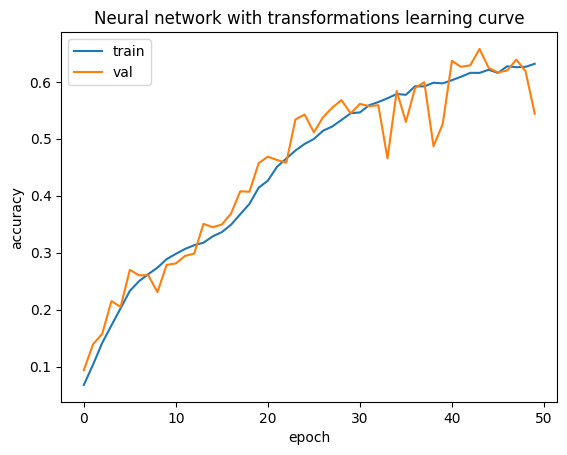

In [19]:
plot_learning_curve(history, title="Neural network with transformations learning curve",save_fig=True)

## CNN - 12-layer Resnet

In [20]:
from dataTransformer import *

cnn_model = tf.keras.Sequential([
  
  tf.keras.layers.Conv2D(32, 7,padding='same',strides=1),#56x56
  ResnetBlock(5,filt=64,filt_in=32,num=2,stride=2),#28x28
  ResnetBlock(5,filt=64,num=2),

  ResnetBlock(3,filt=128,filt_in=64,num=2,stride=2),#14x14
  ResnetBlock(3,filt=128,filt_in=128,num=2),

  ResnetBlock(3,filt=256,filt_in=128,num=2,stride=2),#7x7
  ResnetBlock(3,filt=256,filt_in=256,num=2),

  tf.keras.layers.AveragePooling2D(7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes)
])
cnn_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
cnn_model.build([None,*INPUT_SHAPE])
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 32)        4736      
                                                                 
 resnet_block (ResnetBlock)  (None, 28, 28, 64)        205760    
                                                                 
 resnet_block_1 (ResnetBlock  (None, 28, 28, 64)       308160    
 )                                                               
                                                                 
 resnet_block_2 (ResnetBlock  (None, 14, 14, 128)      296832    
 )                                                               
                                                                 
 resnet_block_3 (ResnetBlock  (None, 14, 14, 128)      296192    
 )                                                               
                                                      

this model has only 3.4M params but preforms much better

In [21]:
history = cnn_model.fit(
  train_ds_t,
  callbacks=[],
  validation_data=val_ds_t,
  epochs=20)


Epoch 1/20
1632/1632 [==============================] - 40s 21ms/step - loss: 1.5400 - accuracy: 0.5346 - val_loss: 1.0166 - val_accuracy: 0.6684
Epoch 2/20
1632/1632 [==============================] - 31s 19ms/step - loss: 0.2846 - accuracy: 0.9080 - val_loss: 0.4134 - val_accuracy: 0.8814
Epoch 3/20
1632/1632 [==============================] - 28s 17ms/step - loss: 0.1389 - accuracy: 0.9543 - val_loss: 0.2218 - val_accuracy: 0.9231
Epoch 4/20
1632/1632 [==============================] - 46s 28ms/step - loss: 0.0950 - accuracy: 0.9688 - val_loss: 0.2835 - val_accuracy: 0.9131
Epoch 5/20
1632/1632 [==============================] - 52s 32ms/step - loss: 0.0688 - accuracy: 0.9777 - val_loss: 0.1022 - val_accuracy: 0.9666
Epoch 6/20
1632/1632 [==============================] - 48s 29ms/step - loss: 0.0566 - accuracy: 0.9813 - val_loss: 0.0784 - val_accuracy: 0.9755
Epoch 7/20
1632/1632 [==============================] - 32s 20ms/step - loss: 0.0464 - accuracy: 0.9849 - val_loss: 0.2150 -

In [22]:
cnn_model_res = evaluate_model(cnn_model,test_ds_t,verbose=3,savePath="resnet_model.keras")

544/544 [==============================] - 6s 11ms/step - loss: 0.0180 - accuracy: 0.9942
Test loss: 0.018046807497739792
Test accuracy: 0.9941927194595337
Model saved to resnet_model.keras


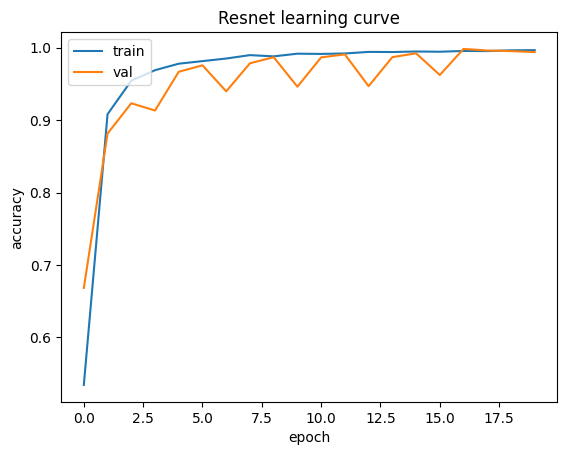

In [23]:
plot_learning_curve(history,title="Resnet learning curve",save_fig=True)

## Comparison

In [24]:
confusion_matrix(lr_model,test_ds,class_names,title="Logistic Regression",save_fig=True)

NameError: name 'lr_model' is not defined

tf.Tensor([10 15  9 ... 26 16 11], shape=(17392,), dtype=int32)


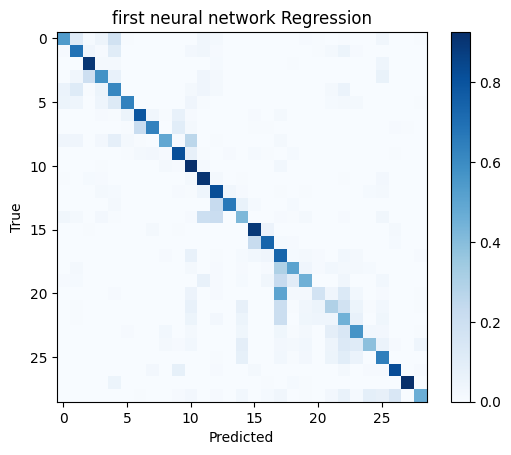

In [ ]:
confusion_matrix(nn_model,test_ds,class_names,title="Neural network",save_fig=True)

tf.Tensor([10 15  9 ... 26 16 11], shape=(17392,), dtype=int32)


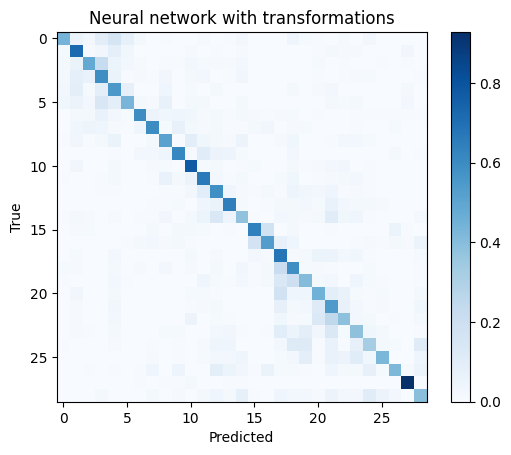

In [26]:
confusion_matrix(nn_model_t,test_ds_t,class_names,title="Neural network with transformations",save_fig=True)

tf.Tensor([10 15  9 ... 26 16 11], shape=(17392,), dtype=int32)


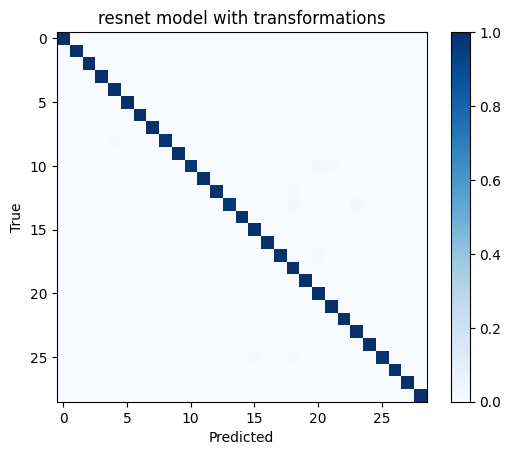

In [27]:
confusion_matrix(cnn_model,test_ds_t,class_names,title="resnet model with transformations",save_fig=True)